In [74]:
import matplotlib.pyplot as plt


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

# Start - CF

In [75]:
import pandas as pd
from scipy.spatial.distance import cosine
import numpy as np
from scipy.stats import pearsonr

In [76]:
utility_matrix = pd.DataFrame.from_csv("utility_matrix.csv")

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [77]:
utility_matrix

,2054145,1435307,575830,808966,2297863,2222089,327691,752642,1706000,1648657
1,3,0,5,0,1,1,0,2,1,2
2,4,3,0,0,0,0,0,1,3,0
3,5,3,4,2,1,2,0,2,1,0
4,0,0,2,5,4,0,0,0,0,0
5,2,1,0,4,0,4,0,1,0,0
6,0,1,1,0,0,0,5,3,0,4
7,0,0,0,2,0,0,0,4,4,0
8,0,1,3,0,0,0,4,0,5,3


In [78]:
print(utility_matrix.columns)

Index([u'2054145', u'1435307', u'575830', u'808966', u'2297863', u'2222089',
       u'327691', u'752642', u'1706000', u'1648657'],
      dtype='object')


In [79]:
columns = [int(c) for c in utility_matrix.columns]
index = [int(i) for i in utility_matrix.index]
utility_matrix.columns = columns
utility_matrix.index = index

In [80]:
data_ubs = pd.DataFrame(index = columns, columns = columns)

In [81]:
utility_matrix = utility_matrix

In [138]:
def pearson(x, y):
    temp_x = np.array(x)
    temp_y = np.array(y)
    notnullx = np.where(temp_x != 0)[0]
    notnully = np.where(temp_y != 0)[0]
    indices = list(set(notnullx) & set(notnully))
    p = pearsonr(temp_x[indices], temp_y[indices])[0]
    return p if p == p else 0

In [139]:
for ind in columns:
    for col in columns:
        c = pearson(utility_matrix.loc[:, ind], utility_matrix.loc[:, col])
        data_ubs.loc[ind, col] = c

In [140]:
data_ubs

,2054145,1435307,575830,808966,2297863,2222089,327691,752642,1706000,1648657
2054145,1,0.944911,-1,-1,0,-0.5,0,0.447214,0,0
1435307,0.944911,1,0.755929,-1,0,-1,0,-0.301511,-0.866025,0
575830,-1,0.755929,1,-1,-0.944911,-1,-1,-0.970725,-0.866025,-1
808966,-1,-1,-1,1,1,1,0,-0.755929,0,0
2297863,0,0,-0.944911,1,1,0,0,0,0,0
2222089,-0.5,-1,-1,1,0,1,0,-0.944911,0,0
327691,0,0,-1,0,0,0,1,0,0,1
752642,0.447214,-0.301511,-0.970725,-0.755929,0,-0.944911,0,1,0.485662,1
1706000,0,-0.866025,-0.866025,0,0,0,0,0.485662,1,1
1648657,0,0,-1,0,0,0,1,1,1,1


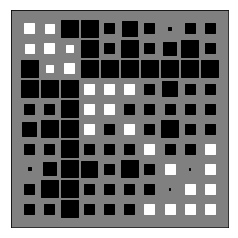

In [141]:
hinton(np.array(data_ubs) - 0.5)

In [142]:
data_neighbours = pd.DataFrame(index = columns, columns = [str(x) for x in range(1,6)])

In [143]:
for i in data_ubs.columns:
    data_neighbours.loc[i, :5] = data_ubs.loc[:, i].sort_values(ascending=False)[:5].index

In [144]:
data_neighbours

,1,2,3,4,5
2054145,2054145,1435307,752642,1648657,1706000
1435307,1435307,2054145,575830,1648657,327691
575830,575830,1435307,1706000,2297863,752642
808966,2222089,2297863,808966,1648657,1706000
2297863,2297863,808966,1648657,1706000,752642
2222089,2222089,808966,1648657,1706000,327691
327691,1648657,327691,1706000,752642,2222089
752642,1648657,752642,1706000,2054145,327691
1706000,1648657,1706000,752642,327691,2222089
1648657,1648657,1706000,752642,327691,2222089


In [145]:
data_pb = pd.DataFrame(index = index, columns = columns)

In [146]:
def getScore(rating, similarities):
    return sum(rating * similarities) / sum(similarities)

In [147]:
for product in index:
    for user in columns:
        if utility_matrix.at[product, user] == 0:
            users_top_names = data_neighbours.loc[user][1:5]
            users_top_sims = data_ubs.loc[user].sort_values(ascending = False)[1:5]
            product_rank = utility_matrix.loc[product, users_top_names]
            data_pb.at[product, user] = getScore(np.array(product_rank), np.array(users_top_sims))
        else:
            data_pb.at[product, user] = utility_matrix.at[product, user]

In [148]:
data_pb

,2054145,1435307,575830,808966,2297863,2222089,327691,752642,1706000,1648657
1,3,3.88889,5,0.5,1,1,0,2,1,2
2,4,3,0.642244,0,0,0,0,1,3,1.33333
3,5,3,4,2,1,2,0,2,1,1
4,0,0.888889,2,5,4,5,0,0,0,0
5,2,1,0.106034,4,4,4,0,1,0.326899,0.333333
6,1.64249,1,1,0,0,0,5,3,0.980698,4
7,1.28498,0,3.62684,2,2,2,0,4,4,2.66667
8,0.678755,1,3,0,0,0,4,1.25632,5,3


In [149]:
utility_matrix

,2054145,1435307,575830,808966,2297863,2222089,327691,752642,1706000,1648657
1,3,0,5,0,1,1,0,2,1,2
2,4,3,0,0,0,0,0,1,3,0
3,5,3,4,2,1,2,0,2,1,0
4,0,0,2,5,4,0,0,0,0,0
5,2,1,0,4,0,4,0,1,0,0
6,0,1,1,0,0,0,5,3,0,4
7,0,0,0,2,0,0,0,4,4,0
8,0,1,3,0,0,0,4,0,5,3


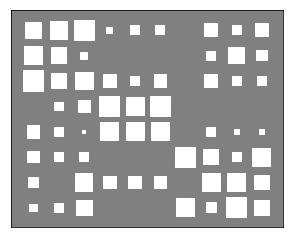

In [150]:
hinton(np.array(data_pb).T)

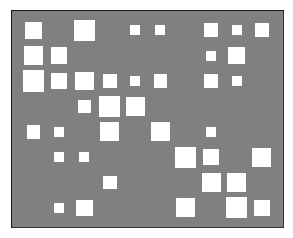

In [151]:
hinton(np.array(utility_matrix.T))